## Checkpoint 1: Data Cleaning 
<br>
Creating master dataframe and solving question for table 1.1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

companiesCSVPath = "companies.csv"
round2CSVPath = "rounds2.csv"
mappingPath = "mapping.csv"

# Reading datasets
companiesDF = pd.read_csv(companiesCSVPath,encoding="palmos",sep=',')
rounds2DF = pd.read_csv(round2CSVPath,encoding='palmos',sep=',')

#dropping unnecessary columns
companiesDF = companiesDF.drop(["homepage_url","status","state_code","region","city","founded_at"],axis=1)
rounds2DF = rounds2DF.drop(["funding_round_permalink","funding_round_code","funded_at"],axis=1)


# Cleaning data
rounds2DF = rounds2DF[~np.isnan(rounds2DF['raised_amount_usd'])]
companiesDF = companiesDF[companiesDF["category_list"].notnull() & companiesDF["country_code"].notnull()]

# Converting to lowercase for equality comparison 
companiesDF["permalink"] = companiesDF["permalink"].str.lower()
rounds2DF["company_permalink"] = rounds2DF["company_permalink"].str.lower()

In [2]:
# Finding unique companies in companies and round2
uniqueCompaniesCompanies = companiesDF["permalink"].drop_duplicates(inplace=False)
uniqueRound2Companies = rounds2DF["company_permalink"].drop_duplicates(inplace=False)

print("Unique Companies in Companies",uniqueCompaniesCompanies.count())
print("Unique Companies in Round2",uniqueRound2Companies.count())

# # Checking if some companies are present in round2 and not in companies
isInCompany = rounds2DF["company_permalink"].isin(uniqueCompaniesCompanies).to_frame();
isInCompany = isInCompany[isInCompany["company_permalink"] == False]
disconnectedCompanies = len(isInCompany.index);

if disconnectedCompanies > 0 :
    print("some companies are there in round2 and not in companies")
else:
    print("both companies and round2 have same companies")

Unique Companies in Companies 57804
Unique Companies in Round2 53915
some companies are there in round2 and not in companies


In [3]:
#Creating master frame
master_frame= pd.merge(companiesDF,rounds2DF,how="inner",left_on="permalink",right_on="company_permalink")
print("Total rows in Master Frame : ",len(master_frame.index))

Total rows in Master Frame :  88529


## Checkpoint 2: Funding Type analysis 
<br>
Creating master dataframe and solving question for table 1.1m

In [4]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)


##Grouping the data based on required funding types and calculating the average funding  
byRoundTypeInvestment = master_frame[master_frame.funding_round_type.isin(["seed","angel","private_equity","venture"])]
byInvestment = byRoundTypeInvestment.groupby("funding_round_type").mean()["raised_amount_usd"].reset_index().sort_values(by="raised_amount_usd",ascending=0)
byInvestment.head(4)



,funding_round_type,raised_amount_usd
1,private_equity,73938486.275
3,venture,11724222.690
0,angel,971573.891
2,seed,747793.682


### Checkpoint 3: Country Analysis
<br>
Calculating top 9 english speaking countries based on investment amount 
<br>
Selected Funding Type : <b>Venture</b>

In [5]:

ventureInvestments = master_frame[master_frame["funding_round_type"] == "venture"].copy()

## list of codes of english speaking countries
englishSpeakingCountries = ["AUS","NZL","GBR","USA","ATG","BHS","BRB","BLZ","BWA","BDI","CMR","CAN","COK","DMA","SWZ","FJI","GMB","GHA","GRD","GUY","IND","IRL","JAM","KEN","KIR","LSO","LBR","MWI","MLT","MHL","MUS","FSM","NAM","NRU","NGA","NIU","PAK","PLW","PNG","PHL","RWA","KNA","LCA","VCT","WSM","SYC","SLE","SGP","SLB","ZAF","SSD","SDN","TZA","TON","TTO","TUV","UGA","VUT","ZMB","ZWE"]

#top 9 english speaking countries based on investment in the required funding type
top9= pd.DataFrame(ventureInvestments.groupby("country_code")["raised_amount_usd"].sum().reset_index().nlargest(9,"raised_amount_usd"))
top3 = top9[top9["country_code"].isin(englishSpeakingCountries)].head()[0:3]
print("Top 9 Countries by total investment :")
display(top9)
print("Top 3 English Speaking Countries by total investment :")
display(top3)

Top 9 Countries by total investment :


,country_code,raised_amount_usd
94,USA,420068029342.000
15,CHN,39338918773.000
29,GBR,20072813004.000
39,IND,14261508718.000
12,CAN,9482217668.000
28,FRA,7226851352.000
42,ISR,6854350477.000
21,DEU,6306921981.000
45,JPN,3167647127.000


Top 3 English Speaking Countries by total investment :


,country_code,raised_amount_usd
94,USA,420068029342.000
29,GBR,20072813004.000
39,IND,14261508718.000


### Checkpoint 4: Sector Analysis 1
<br>
Extracting primary sector and mapping of main sector based on primary sector

In [6]:
# ##reading mapping file
mappingDf = pd.read_csv(mappingPath)
mappingDf = mappingDf[1:]

# Correcting spelling mistake using regex
mappingDf["category_list"] = mappingDf["category_list"].replace({"0":"na"},regex=True)

# Creating mapping
mainSectors =  mappingDf.columns.tolist()[1:]
m = pd.melt(mappingDf,id_vars=["category_list"], value_vars=mainSectors,var_name="main_sector")
temp = m[m["value"] == 1]
temp.set_index("category_list",inplace=True)
mapping = temp.to_dict("index")

def getMainSector(primary):
    if primary in mapping.keys():
        return mapping[primary]["main_sector"]
    else:
        return "NA"

GetMainSector = np.vectorize(getMainSector)

# creating columns for primary sector and main sector in the main
ventureInvestments["primary_sector"] = ventureInvestments["category_list"].str.split("|").str[0]

ventureInvestments["main_sector"] = GetMainSector(ventureInvestments["primary_sector"])

#imputing rows with "NA" Category
ventureInvestments = ventureInvestments[ventureInvestments["main_sector"] != "NA"]
ventureInvestments

,permalink,name,category_list,country_code,company_permalink,funding_round_type,raised_amount_usd,primary_sector,main_sector
0,/organization/-fame,#fame,Media,IND,/organization/-fame,venture,10000000.000,Media,Entertainment
2,/organization/0-6-com,0-6.com,Curated Web,CHN,/organization/0-6-com,venture,2000000.000,Curated Web,"News, Search and Messaging"
5,/organization/0ndine-biomedical-inc,Ondine Biomedical Inc.,Biotechnology,CAN,/organization/0ndine-biomedical-inc,venture,719491.000,Biotechnology,Cleantech / Semiconductors
7,/organization/0xdata,H2O.ai,Analytics,USA,/organization/0xdata,venture,20000000.000,Analytics,"Social, Finance, Analytics, Advertising"
8,/organization/0xdata,H2O.ai,Analytics,USA,/organization/0xdata,venture,1700000.000,Analytics,"Social, Finance, Analytics, Advertising"
...,...,...,...,...,...,...,...,...,...
88513,/organization/zyraz-technology,Zyraz Technology,Biotechnology,MYS,/organization/zyraz-technology,venture,7991547.000,Biotechnology,Cleantech / Semiconductors
88516,/organization/zyrra,Zyrra,E-Commerce,USA,/organization/zyrra,venture,140500.000,E-Commerce,Others
88518,/organization/zystor,Zystor,Biotechnology,USA,/organization/zystor,venture,8500000.000,Biotechnology,Cleantech / Semiconductors
88519,/organization/zytoprotec,Zytoprotec,Biotechnology,AUT,/organization/zytoprotec,venture,2686600.000,Biotechnology,Cleantech / Semiconductors


### Checkpoint 5: Sector Analysis 2
<br>
Sector analysis of top 3 countries based on funding types

In [7]:
 # extracting companies permalink whose average amount of investment is between 5 and 15 million for particular rounds
byCompany  = ventureInvestments.groupby( ["permalink"])
byCompany = byCompany.filter(lambda x: x["raised_amount_usd"].sum() > 5000000 and x["raised_amount_usd"].sum() < 15000000)
companiesList = byCompany["permalink"].tolist()


#filtering investments based on permalinks extracted from above 
rangeInvestment = ventureInvestments[ventureInvestments["permalink"].isin(companiesList)]


In [8]:
# extracting top 3 countries as list
top3Countries = top3["country_code"].tolist()[:3]
print(top3Countries)

['USA', 'GBR', 'IND']


In [10]:
## Code for top country
CountryInvestment = rangeInvestment[rangeInvestment["country_code"] == top3Countries[0]].copy()
D1t = CountryInvestment.groupby(["main_sector"]).agg({"raised_amount_usd":["sum","count"]}).reset_index().rename(columns={"sum":"Investment_Amount","count":"Investments"})

## to flatten the index and remove the multi-index warning
D1t.columns = D1t.columns.map(' '.join).str.strip()
D1 = pd.merge(CountryInvestment,D1t,how="inner",right_on="main_sector",left_on="main_sector")

print("Top Country :",top3Countries[0])

#Total count of investments(count)
print("total number of investments :",D1t["raised_amount_usd Investments"].unique().sum())

#Total amount of investments
print("total amount of investments :",D1t["raised_amount_usd Investment_Amount"].unique().sum())

## top sector investment count wise
print("\nTop 3 Sectors :")
display(D1t.nlargest(3,"raised_amount_usd Investments"))

## creating a list of top 2 sectors for further use
top2MainSectors = D1t.nlargest(2,"raised_amount_usd Investments")["main_sector"].tolist()

# ## Highest investment of top company
print("\nHighest investment top sector :")
display(CountryInvestment[CountryInvestment["main_sector"] == top2MainSectors[0]].groupby("name")["raised_amount_usd"].sum().nlargest(1))

# ## Highest investment of second top company
print("\nHighest investment top second sector :")
display(CountryInvestment[CountryInvestment["main_sector"] == top2MainSectors[1]].groupby("name")["raised_amount_usd"].sum().nlargest(1))


Top Country : USA
total number of investments : 7666
total amount of investments : 41493186794.0

Top 3 Sectors :


,main_sector,raised_amount_usd Investment_Amount,raised_amount_usd Investments
6,Others,10540109833.000,1862
7,"Social, Finance, Analytics, Advertising",9099090999.000,1694
1,Cleantech / Semiconductors,7284168557.000,1446



Highest investment top sector :


name
KoolSpan   14800000.000
Name: raised_amount_usd, dtype: float64


Highest investment top second sector :


name
Fundera   14900000.000
Name: raised_amount_usd, dtype: float64

In [11]:
## Code for top second country
CountryInvestment = rangeInvestment[rangeInvestment["country_code"] == top3Countries[1]].copy()
D2t = CountryInvestment.groupby(["main_sector"]).agg({"raised_amount_usd":["sum","count"]}).reset_index().rename(columns={"sum":"Investment_Amount","count":"Investments"})

## to flatten the index and remove the multi-index warning
D2t.columns = D2t.columns.map(' '.join).str.strip()
D2 = pd.merge(CountryInvestment,D2t,how="inner",right_on="main_sector",left_on="main_sector")

print("Top Country :",top3Countries[1])

#Total count of investments(count)
print("total number of investments :",D2t["raised_amount_usd Investments"].unique().sum())

#Total amount of investments
print("total amount of investments :",D2t["raised_amount_usd Investment_Amount"].unique().sum())

## top sector investment count wise
print("\nTop 3 Sectors :")
display(D2t.nlargest(3,"raised_amount_usd Investments"))

## creating a list of top 2 sectors for further use
top2MainSectors = D2t.nlargest(2,"raised_amount_usd Investments")["main_sector"].tolist()

# ## Highest investment of top company
print("\nHighest investment top sector :")
display(CountryInvestment[CountryInvestment["main_sector"] == top2MainSectors[0]].groupby("name")["raised_amount_usd"].sum().nlargest(1))

# ## Highest investment of second top company
print("\nHighest investment top second sector :")
display(CountryInvestment[CountryInvestment["main_sector"] == top2MainSectors[1]].groupby("name")["raised_amount_usd"].sum().nlargest(1))


Top Country : GBR
total number of investments : 528
total amount of investments : 3097978653.0

Top 3 Sectors :


,main_sector,raised_amount_usd Investment_Amount,raised_amount_usd Investments
6,Others,810930748.000,151
7,"Social, Finance, Analytics, Advertising",619481410.000,114
1,Cleantech / Semiconductors,649824691.000,108



Highest investment top sector :


name
KaliteUKASH   14400000.000
Name: raised_amount_usd, dtype: float64


Highest investment top second sector :


name
The Exchange Lab   14000000.000
Name: raised_amount_usd, dtype: float64

In [12]:
## Code for third top country
CountryInvestment = rangeInvestment[rangeInvestment["country_code"] == top3Countries[2]].copy()
D3t = CountryInvestment.groupby(["main_sector"]).agg({"raised_amount_usd":["sum","count"]}).reset_index().rename(columns={"sum":"Investment_Amount","count":"Investments"})

## to flatten the index and remove the multi-index warning
D3t.columns = D3t.columns.map(' '.join).str.strip()
D3 = pd.merge(CountryInvestment,D3t,how="inner",right_on="main_sector",left_on="main_sector")

print("Top Country :",top3Countries[2])

#Total count of investments(count)
print("total number of investments :",D3t["raised_amount_usd Investments"].unique().sum())

#Total amount of investments
print("total amount of investments :",D3t["raised_amount_usd Investment_Amount"].unique().sum())

## top sector investment count wise
print("\nTop 3 Sectors :")
display(D3t.nlargest(3,"raised_amount_usd Investment_Amount"))

## creating a list of top 2 sectors for further use
top2MainSectors = D3t.nlargest(2,"raised_amount_usd Investments")["main_sector"].tolist()

# ## Highest investment of top company
print("\nHighest investment top sector :")
display(CountryInvestment[CountryInvestment["main_sector"] == top2MainSectors[0]].groupby("name")["raised_amount_usd"].sum().nlargest(1))

# ## Highest investment of second top company
print("\nHighest investment top second sector :")
display(CountryInvestment[CountryInvestment["main_sector"] == top2MainSectors[1]].groupby("name")["raised_amount_usd"].sum().nlargest(1))

Top Country : IND
total number of investments : 195
total amount of investments : 1325244339.0

Top 3 Sectors :


,main_sector,raised_amount_usd Investment_Amount,raised_amount_usd Investments
6,Others,440131762.000,67
7,"Social, Finance, Analytics, Advertising",248483500.000,36
5,"News, Search and Messaging",160449077.000,28



Highest investment top sector :


name
Power2SME   14800000.000
Name: raised_amount_usd, dtype: float64


Highest investment top second sector :


name
FundsIndia   14770000.000
Name: raised_amount_usd, dtype: float64

### Checkpoint 6: Plots

### Plot 1 : Count of total investment and mean amount of investment for seed, angel, private equity and venture

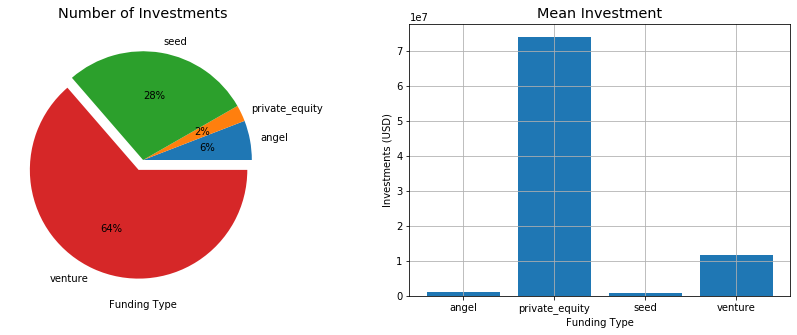

In [17]:
#Graph of Fractional Investment of angel,seed,venture and private equity
meanInvestments = pd.DataFrame(byRoundTypeInvestment.groupby("funding_round_type")["raised_amount_usd"].mean()).reset_index()
countInvestments = pd.DataFrame(byRoundTypeInvestment.groupby("funding_round_type")["raised_amount_usd"].count()).reset_index()
totalInvestmentsCount = byRoundTypeInvestment["raised_amount_usd"].count()
countInvestments["part"] = countInvestments["raised_amount_usd"]/totalInvestmentsCount * 360

fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=False)


axs[1].bar(meanInvestments["funding_round_type"],meanInvestments["raised_amount_usd"])
axs[1].set_title("Mean Investment",fontsize="x-large")
axs[1].set_xlabel("Funding Type")
axs[1].set_ylabel("Investments (USD)")
axs[1].grid()

axs[0].pie(countInvestments["part"],labels=countInvestments["funding_round_type"],explode=(0,0, 0, 0.1),autopct='%1.0f%%')

axs[0].set_title("Number of Investments",fontsize="x-large")
axs[0].set_xlabel("Funding Type")
axs[0].grid()
plt.show()

### Plot 2 : Top 9 countries against total amount of investments

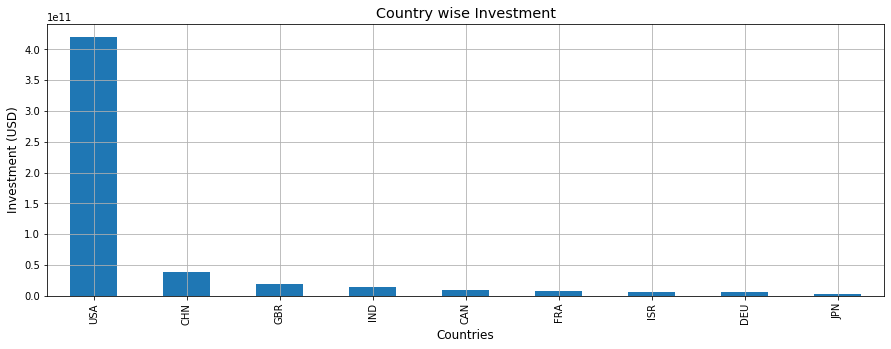

In [19]:
# total amount of investments for top 9 countries for funding types
top9CountriesInvestments = pd.DataFrame(top9).reset_index()
countriesInvestmentChart = top9CountriesInvestments.plot(figsize=(15,5),kind="bar", x="country_code",y="raised_amount_usd")
countriesInvestmentChart.set_title("Country wise Investment",fontsize='x-large')
countriesInvestmentChart.set_xlabel("Countries",fontsize='large')
countriesInvestmentChart.set_ylabel("Investment (USD)",fontsize='large')
countriesInvestmentChart.get_legend().remove()
countriesInvestmentChart.grid()
plt.show()


### Plot 3 : Number of Investments in top 3 sectors in top 3 countries for chosen funding type

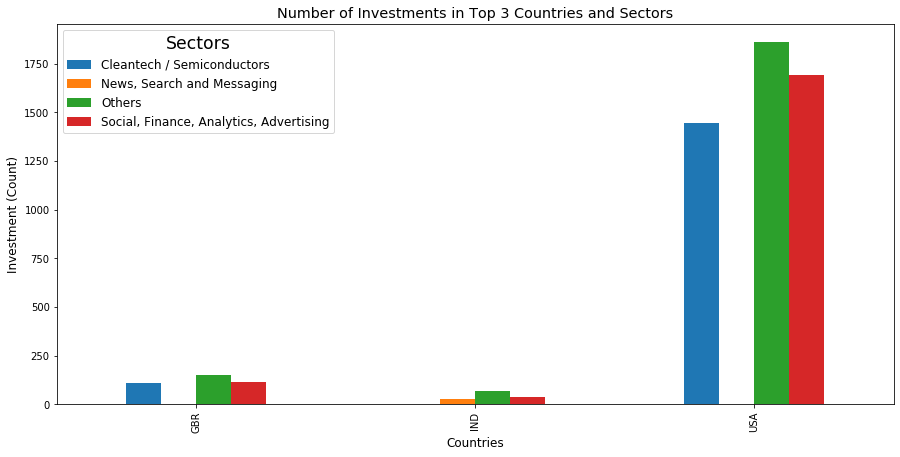

In [28]:
#preparing data
C1 = D1t.nlargest(3,"raised_amount_usd Investment_Amount")
C2 = D2t.nlargest(3,"raised_amount_usd Investment_Amount")
C3 = D3t.nlargest(3,"raised_amount_usd Investment_Amount")
C1["country_code"] = top3Countries[0]
C2["country_code"] = top3Countries[1]
C3["country_code"] = top3Countries[2]

byCountrySector = pd.concat([C1,C2,C3])
byCountrySector.drop(["raised_amount_usd Investment_Amount"],axis=1,inplace=True)
byCountrySector.rename(columns={"raised_amount_usd Investments":"raised_amount_usd"},inplace=True)


#unstacking columns for plotting
byCountrySectorTop3=byCountrySector.groupby(["country_code","main_sector"])["raised_amount_usd"].sum().unstack()


countriesFTInvestmentChart = byCountrySectorTop3.plot(figsize=(15,7),kind="bar")
countriesFTInvestmentChart.set_title("Number of Investments in Top 3 Countries and Sectors",fontsize='x-large')
countriesFTInvestmentChart.set_xlabel("Countries",fontsize='large')
countriesFTInvestmentChart.set_ylabel("Investment (Count)",fontsize='large')
countriesFTInvestmentChart.legend(title="Sectors",fontsize='large',title_fontsize="xx-large")
plt.show()
